# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from tensorflow.keras.models import Model


import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras
import glob
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

## Loading in the data

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.


In [2]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
    
    
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image


def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)


We will now put this all together into a helper function. You can use this directly as is and should be fine to hit the ground running. However, you may modify it to add some additional functionality such as data augmentation if you like.

In [3]:
# putting it all together into one big helper function

def load_oxford_pets(split,
                     batch_size=233,
                     shuffle=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    if (split != 'train') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # HINT: looks like a comfy spot for where some data augmentation might want to live ;)
    
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed 
    # and compatable with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
                 

## Testing the provided data loader.

Let's test it all and plot some examples to make sure they are working. I have provided some bad defaults for the image size and the batch size.

**YOU WILL NEED TO CHANGE THESE**, unless you have access to multiple A100 GPUS for some reason.

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)


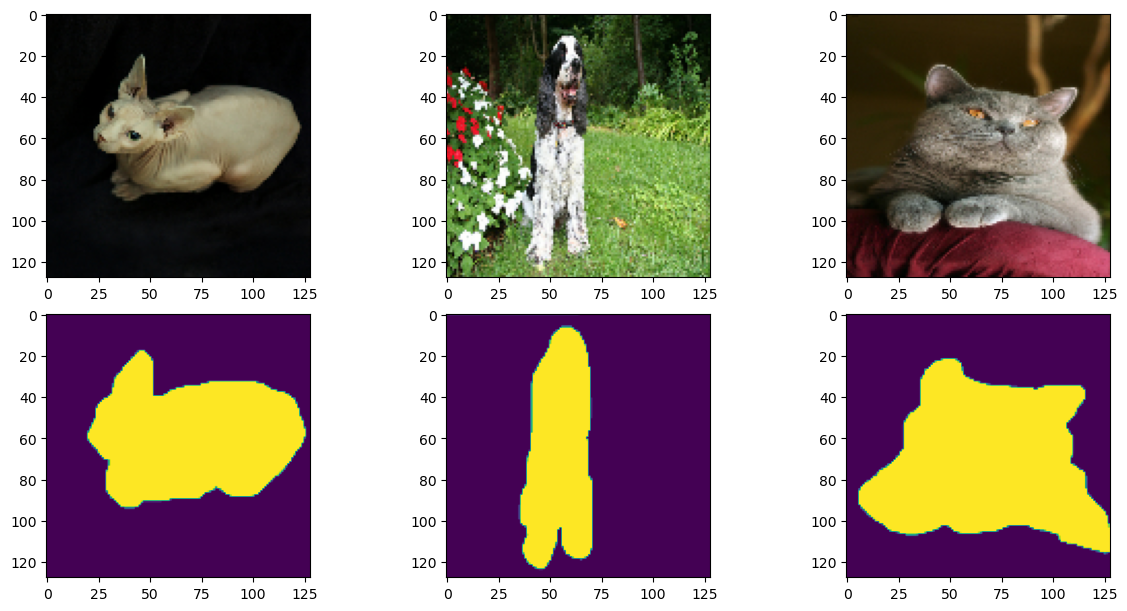

In [4]:
# testing it and plotting some images.
# NOTE: the image size I am setting here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. I am doing this on purpose to force you to 
# pick a suitable batch size yourself
image_size = 128  # Decrease the image size to reduce memory usage
batch_size = 64  # Decrease the batch size to fit within the available GPU memory

train_class_seg_off = load_oxford_pets('train', shuffle=False, batch_size=batch_size, image_size=image_size)

train_class_seg = load_oxford_pets('train', shuffle=True, batch_size=batch_size, image_size=image_size)
test_class_seg = load_oxford_pets('test', shuffle=False, batch_size=batch_size, image_size=image_size)

# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout="constrained")
num_plot = 3
i = 0
# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg_off.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')


### Pre-processing

In [5]:
# train_class_seg_off = train_class_seg_off.map(lambda x, y: preprocess_and_resize(x, y, image_size))
# train_class_seg = train_class_seg.map(lambda x, y: preprocess_and_resize(x, y, image_size))
# test_class_seg = test_class_seg.map(lambda x, y: preprocess_and_resize(x, y, image_size))

In [6]:
!pip install tensorflow_addons

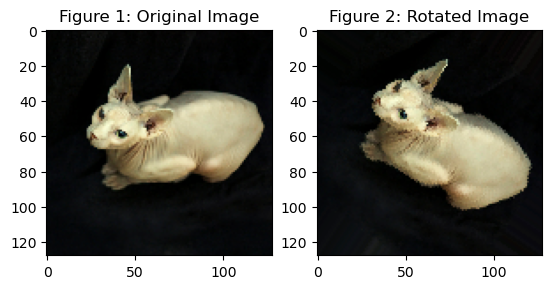

In [7]:
import tensorflow_addons as tfa

def random_rotations(image_batch, label_batch):
    """Apply random rotations to the image batch"""
    max_rotation = 0.785398  # 45 degrees in radians
    rot_val = tf.random.uniform((), minval=-max_rotation, maxval=max_rotation, dtype=tf.float32)
    rotated_images = tfa.image.rotate(image_batch, rot_val, fill_mode='nearest')
    return rotated_images, label_batch

# Apply random rotations to the dataset
ds = train_class_seg_off.map(random_rotations)

# Get the first batch from the dataset (original images and labels)
x_original, y_original = next(iter(train_class_seg_off))

# Get the first batch from the rotated dataset
x_rotated, y_rotated = next(iter(ds))

# Visualize the original and rotated images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(tf.keras.preprocessing.image.array_to_img(x_original[0]))
axs[0].set_title('Figure 1: Original Image')
axs[1].imshow(tf.keras.preprocessing.image.array_to_img(x_rotated[0]))
axs[1].set_title('Figure 2: Rotated Image')
plt.show()


In [8]:
train_class_seg = train_class_seg.map(random_rotations)
train_class_seg_off = train_class_seg.map(random_rotations)

### SELF 

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# Backbone
input_img = Input(shape=(128, 128, 3))
x = Conv2D(8, (3, 3), activation='swish', padding='same')(input_img)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(8, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(64, (3, 3), activation= None, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = SpatialDropout2D(0.2)(x)
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

    # first output, we'll flatten the embedding, and pass it through a couple of dense layers to
    # get our output
class_out = Flatten()(encoded)
class_out = Dense(37, activation='softmax', name='class_output')(class_out)

    # second output, we'll do the usual decode to get our autoencoder output
x = Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
x = Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(16, (3, 3), activation='swish', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = Conv2D(8, (3, 3), activation='swish', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(x)

# Build the model
model_cnn = Model(inputs=input_img, outputs=[class_out, decoded], name='multi_task_model')
# Print the summary
model_cnn.summary()

Model: "multi_task_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d_1[0][0]']

In [10]:

model_cnn.compile(loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
              optimizer=keras.optimizers.Adam(), metrics=[[tf.keras.metrics.SparseCategoricalAccuracy()],[tf.keras.metrics.BinaryAccuracy()]])

history = model_cnn.fit(train_class_seg, epochs=10,#30
                         validation_data=test_class_seg, verbose= True )
# 200 terrible 
# 100 with text augmentation looks bad
# 100 looks overfitting 

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 29s 149ms/step - loss: 4.5753 - class_output_loss: 3.9467 - autoenc_output_loss: 0.6286 - class_output_sparse_categorical_accuracy: 0.0375 - autoenc_output_binary_accuracy: 0.6533 - val_loss: 4.3214 - val_class_output_loss: 3.6424 - val_autoenc_output_loss: 0.6790 - val_class_output_sparse_categorical_accuracy: 0.0273 - val_autoenc_output_binary_accuracy: 0.5731
Epoch 2/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 129ms/step - loss: 4.2013 - class_output_loss: 3.6537 - autoenc_output_loss: 0.5476 - class_output_sparse_categorical_accuracy: 0.0552 - autoenc_output_binary_accuracy: 0.7293 - val_loss: 4.2596 - val_class_output_loss: 3.6871 - val_autoenc_output_loss: 0.5726 - val_class_output_sparse_categorical_accuracy: 0.0273 - val_autoenc_output_binary_accuracy: 0.7200
Epoch 3/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 129ms/step - loss: 4.0390 - class_output_loss: 3.5035 - autoenc_output_loss: 0.5354 - class_output_sparse_categorical_accuracy: 0.0709 - autoenc_output_binary_accuracy: 0.7371 - val_loss: 4.2464 - val_class_output_loss: 3.7145 - val_autoenc_output_loss: 0.5318 - val_class_output_sparse_categorical_accuracy: 0.0273 - val_autoenc_output_binary_accuracy: 0.7400
Epoch 4/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 125ms/step - loss: 3.9000 - class_output_loss: 3.3765 - autoenc_output_loss: 0.5235 - class_output_sparse_categorical_accuracy: 0.0948 - autoenc_output_binary_accuracy: 0.7429 - val_loss: 4.2434 - val_class_output_loss: 3.7137 - val_autoenc_output_loss: 0.5298 - val_class_output_sparse_categorical_accuracy: 0.0273 - val_autoenc_output_binary_accuracy: 0.7404
Epoch 5/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 125ms/step - loss: 3.8334 - class_output_loss: 3.3121 - autoenc_output_loss: 0.5213 - class_output_sparse_categorical_accuracy: 0.0992 - autoenc_output_binary_accuracy: 0.7444 - val_loss: 4.3684 - val_class_output_loss: 3.8421 - val_autoenc_output_loss: 0.5263 - val_class_output_sparse_categorical_accuracy: 0.0273 - val_autoenc_output_binary_accuracy: 0.7410
Epoch 6/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 125ms/step - loss: 3.7590 - class_output_loss: 3.2443 - autoenc_output_loss: 0.5146 - class_output_sparse_categorical_accuracy: 0.1177 - autoenc_output_binary_accuracy: 0.7478 - val_loss: 4.4317 - val_class_output_loss: 3.9071 - val_autoenc_output_loss: 0.5246 - val_class_output_sparse_categorical_accuracy: 0.0283 - val_autoenc_output_binary_accuracy: 0.7416
Epoch 7/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 126ms/step - loss: 3.7038 - class_output_loss: 3.1880 - autoenc_output_loss: 0.5158 - class_output_sparse_categorical_accuracy: 0.1293 - autoenc_output_binary_accuracy: 0.7475 - val_loss: 4.4090 - val_class_output_loss: 3.8833 - val_autoenc_output_loss: 0.5258 - val_class_output_sparse_categorical_accuracy: 0.0371 - val_autoenc_output_binary_accuracy: 0.7409
Epoch 8/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 125ms/step - loss: 3.6718 - class_output_loss: 3.1591 - autoenc_output_loss: 0.5127 - class_output_sparse_categorical_accuracy: 0.1424 - autoenc_output_binary_accuracy: 0.7499 - val_loss: 4.1575 - val_class_output_loss: 3.6358 - val_autoenc_output_loss: 0.5217 - val_class_output_sparse_categorical_accuracy: 0.0431 - val_autoenc_output_binary_accuracy: 0.7410
Epoch 9/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 124ms/step - loss: 3.5818 - class_output_loss: 3.0776 - autoenc_output_loss: 0.5042 - class_output_sparse_categorical_accuracy: 0.1603 - autoenc_output_binary_accuracy: 0.7537 - val_loss: 4.3846 - val_class_output_loss: 3.8465 - val_autoenc_output_loss: 0.5381 - val_class_output_sparse_categorical_accuracy: 0.0512 - val_autoenc_output_binary_accuracy: 0.7325
Epoch 10/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 126ms/step - loss: 3.5352 - class_output_loss: 3.0329 - autoenc_output_loss: 0.5023 - class_output_sparse_categorical_accuracy: 0.1658 - autoenc_output_binary_accuracy: 0.7549 - val_loss: 4.0878 - val_class_output_loss: 3.5802 - val_autoenc_output_loss: 0.5076 - val_class_output_sparse_categorical_accuracy: 0.0700 - val_autoenc_output_binary_accuracy: 0.7508


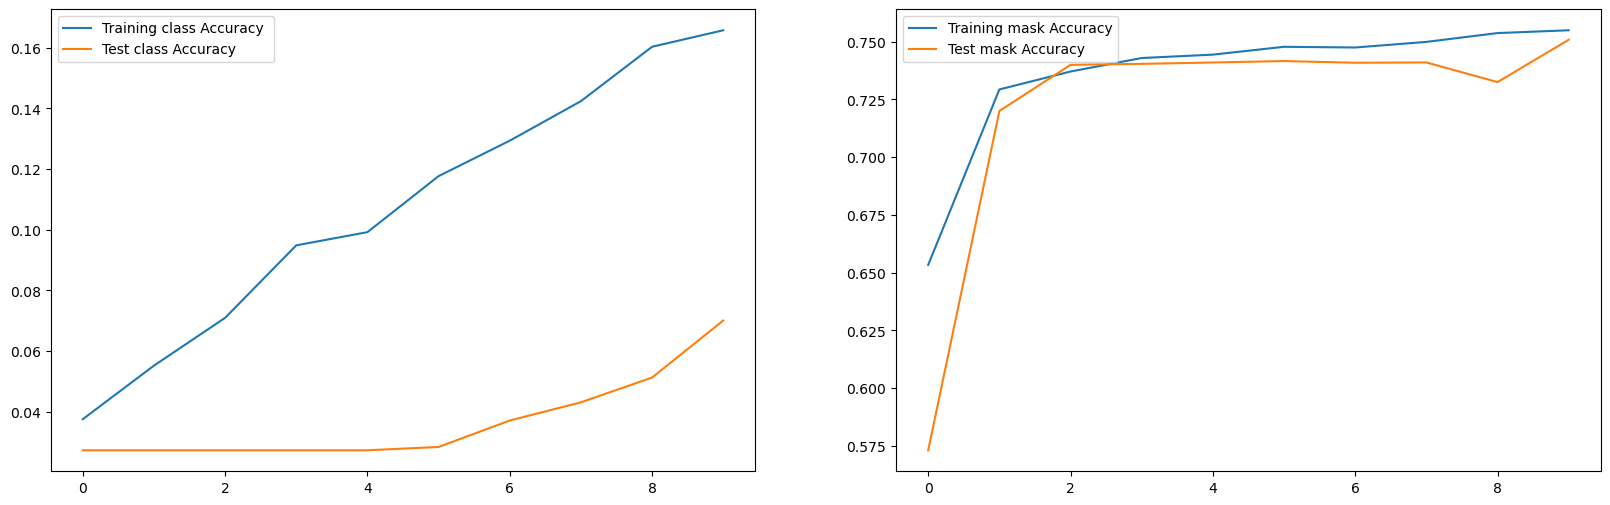

In [11]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)

ax.plot(history.history['class_output_sparse_categorical_accuracy'], label="Training class Accuracy ")
ax.plot(history.history['val_class_output_sparse_categorical_accuracy'], label="Test class Accuracy ")

ax.legend()

ax = fig.add_subplot(1, 2, 2)

ax.plot(history.history['autoenc_output_binary_accuracy'], label="Training mask Accuracy")
ax.plot(history.history['val_autoenc_output_binary_accuracy'], label="Test mask Accuracy")
ax.legend()

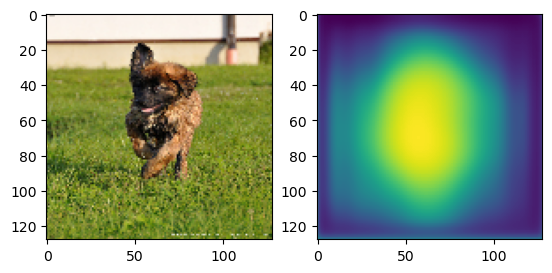

In [12]:
x, y = next(iter(test_class_seg))
classification, decoded = model_cnn(x)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(tf.keras.preprocessing.image.array_to_img(x[0]))
axs[1].imshow(tf.keras.preprocessing.image.array_to_img(decoded[0]))

In [13]:
def eval_model(pred_train, train, train_y, pred_test, test, test_y):
    train_indexes = tf.argmax(pred_train, axis=1)
    test_indexes = tf.argmax(pred_test, axis=1)

    train_cm = confusion_matrix(train_y, train_indexes)
    test_cm = confusion_matrix(test_y, test_indexes)

    fig, axes = plt.subplots(1, 2, figsize=[20, 10])

    ax1 = axes[0]
    ax1.set_title('Training, F1 Score: %f' % f1_score(train_y, train_indexes, average='weighted'))
    train_cm_display = ConfusionMatrixDisplay(train_cm)
    train_cm_display.plot(ax=ax1)

    ax2 = axes[1]
    ax2.set_title('Testing, F1 Score: %f' % f1_score(test_y, test_indexes, average='weighted'))
    test_cm_display = ConfusionMatrixDisplay(test_cm)
    test_cm_display.plot(ax=ax2)

    plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 2s 41ms/step


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


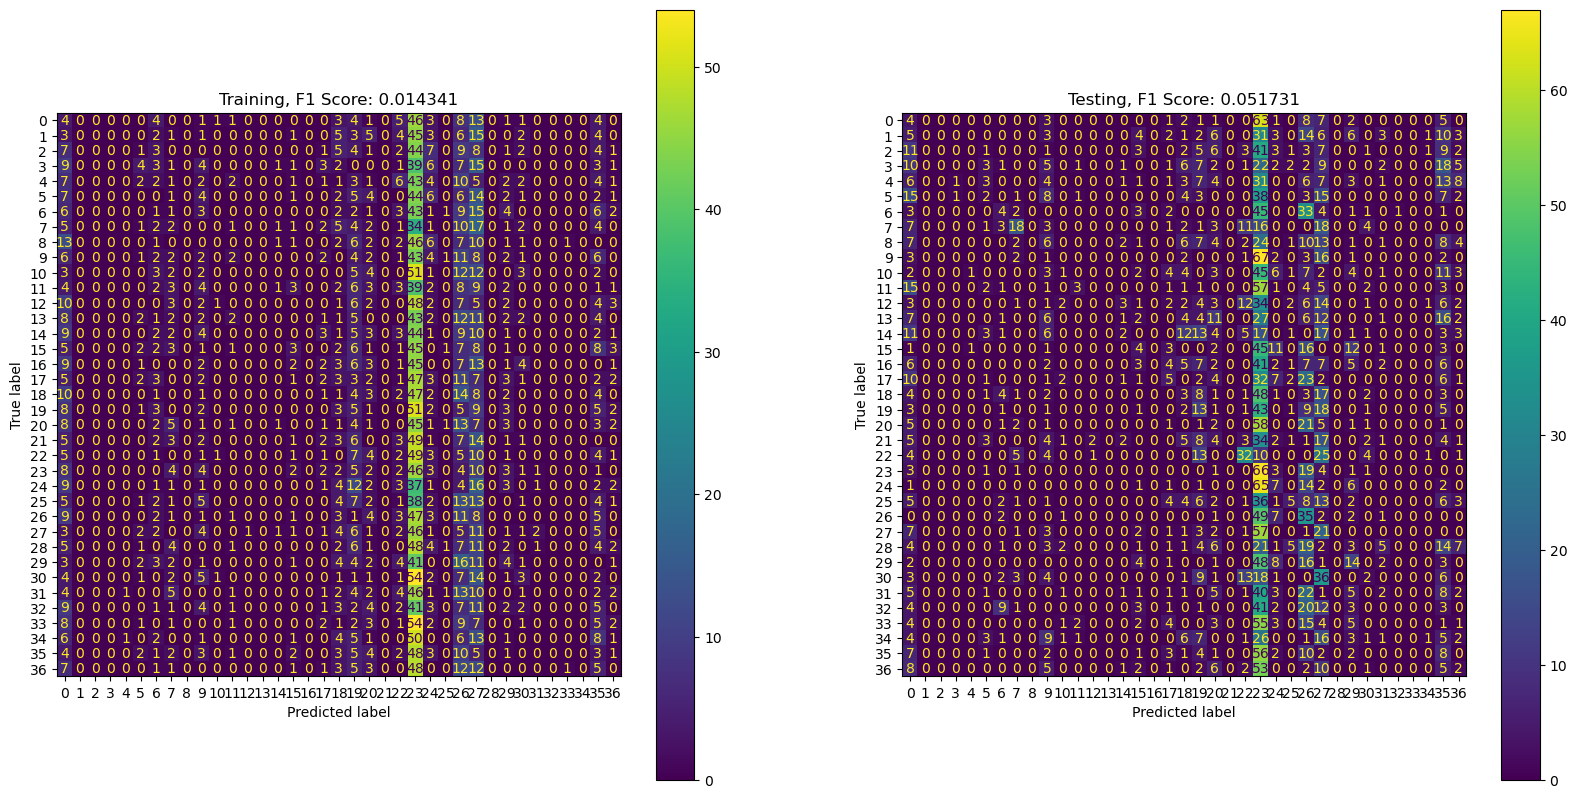

In [14]:
class_train, seg_train = model_cnn.predict(train_class_seg_off)
class_results, mask_results= model_cnn.predict(test_class_seg)
# predicted_labels = np.argmax(class_results, axis =1)
 
y_train_class =np.concatenate([y[0] for x,y in train_class_seg_off.as_numpy_iterator()])
y_train_seg = np.concatenate([y[1] for x,y in train_class_seg_off.as_numpy_iterator()])
y_test_class =np.concatenate([y[0] for x,y in test_class_seg.as_numpy_iterator()])
y_test_seg = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])

# eval_model_1(class_train, train_class_seg_off, y_train_class)
# eval_model_1(class_results, test_class_seg, y_test_class)
eval_model(class_train, train_class_seg_off, y_train_class, class_results, test_class_seg, y_test_class)

58/58 [==============================] - 2s 41ms/step


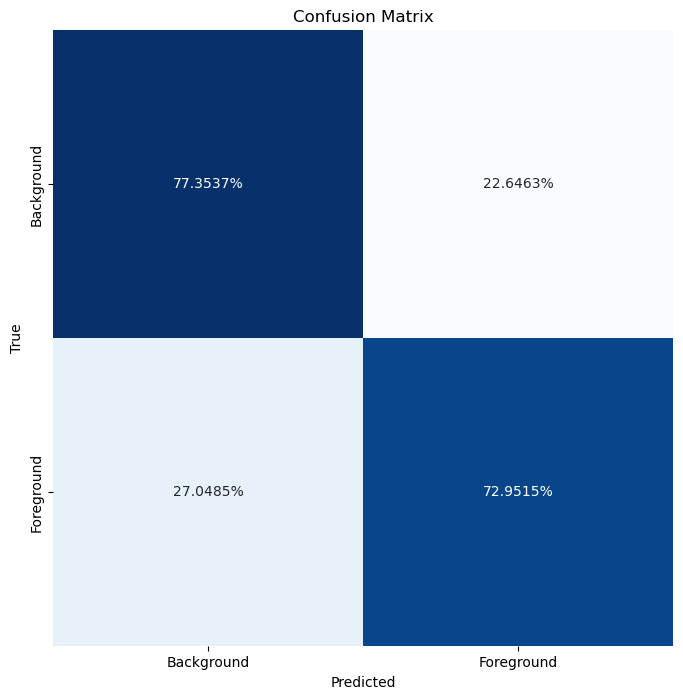

In [15]:
# class_preds, seg_preds = model_cnn.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = some_pred_y_data.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector

##### Simon email 
class_preds, seg_preds = model_cnn.predict(test_class_seg)
seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
seg_gt_flat = y_test_seg.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector


cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat, normalize='true')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt=".4%", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Background', 'Foreground'])
ax.yaxis.set_ticklabels(['Background', 'Foreground'])

# Display the plot
plt.show()


In [16]:
# cm = cm = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)
# fig = plt.figure(figsize= [10,10])
# ax = fig.add_subplot(1,1,1)
# c = ConfusionMatrixDisplay(cm)
# c.plot(ax=ax)

In [17]:
# def evaluate_decoded_images(decoded_imgs, test_images, pred, pred_y,):
#     # Calculate evaluation metrics for decoded images
#     rmse = np.sqrt(np.mean((test_images - decoded_imgs) ** 2))
#     values= tf.argmax(pred, axis=1)
#     #ori_values =tf.argmax(pred_y, axis=1)
#     print("Mean Squared Error (MSE):", rmse)
#     fig = plt.figure(figsize=[25, 10])


#     fig = plt.figure(figsize=[25, 15])
#     count = 0

#     for i in range(1):
#         for j in range(4):
#             ax = fig.add_subplot(2, 6, count + 1)
#             ax.imshow(np.squeeze(test_images[j]))
#             ax.set_title('True Class Label: {}'.format(pred_y[j]))
#             count+= 1
#             ax = fig.add_subplot(2, 6, count+ 1)
#             ax.imshow(np.squeeze(decoded_imgs[j]))
#             ax.set_title('Predicted Class Label: {}'.format(values[j]));
#             count+= 1
#     plt.show()


In [18]:
# # Extract seg labels
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat)
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(1,1,1)
# c = ConfusionMatrixDisplay(cm)
# c.plot(ax=ax)



# Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from Tensorflow. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False.
    This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

In [19]:
mobile_base = tf.keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

In [20]:
# mobile_base.summary()

In [21]:
mobile_base.trainable = False
# mobile_base.summary()

In [22]:
from tensorflow.keras import layers
# setting up base network / encoder to get embedding
inputs = layers.Input((image_size, image_size, 3))
embedding = mobile_base(inputs)

# classification output
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
classification = layers.Dense(37, activation=None, name='classification')(flattened)

# decoder
x =  layers.UpSampling2D((3, 3))(embedding)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)


# output - for binary semantic segmentation - one channel
x =  layers.Conv2D(1, (1, 1), activation=None, padding='same')(x)
decoded = keras.layers.Resizing(image_size, image_size)(x)

mobile_model = keras.Model(inputs, [classification, decoded])
mobile_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 4, 4, 576)    939120      ['input_3[0][0]']                
                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 12, 12, 576)  0          ['MobilenetV3small[0][0]']       
                                                                                                  
 conv2d_32 (Conv2D)             (None, 12, 12, 64)   331840      ['up_sampling2d_4[0][0]']    

In [23]:
mobile_model.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           keras.losses.MeanSquaredError()],
                  optimizer='adam')

In [24]:
history = mobile_model.fit(train_class_seg, epochs=10,
                     validation_data=test_class_seg)

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 14s 138ms/step - loss: 3.3519 - classification_loss: 3.1902 - resizing_loss: 0.1617 - val_loss: 2.4495 - val_classification_loss: 2.3326 - val_resizing_loss: 0.1170
Epoch 2/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 8s 118ms/step - loss: 2.2887 - classification_loss: 2.1612 - resizing_loss: 0.1276 - val_loss: 1.9040 - val_classification_loss: 1.7954 - val_resizing_loss: 0.1086
Epoch 3/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 112ms/step - loss: 1.8903 - classification_loss: 1.7685 - resizing_loss: 0.1218 - val_loss: 1.6683 - val_classification_loss: 1.5631 - val_resizing_loss: 0.1052
Epoch 4/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 114ms/step - loss: 1.6565 - classification_loss: 1.5406 - resizing_loss: 0.1159 - val_loss: 1.5533 - val_classification_loss: 1.4559 - val_resizing_loss: 0.0974
Epoch 5/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 116ms/step - loss: 1.5095 - classification_loss: 1.3946 - resizing_loss: 0.1149 - val_loss: 1.4750 - val_classification_loss: 1.3778 - val_resizing_loss: 0.0972
Epoch 6/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 114ms/step - loss: 1.4635 - classification_loss: 1.3469 - resizing_loss: 0.1166 - val_loss: 1.4311 - val_classification_loss: 1.3372 - val_resizing_loss: 0.0939
Epoch 7/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 115ms/step - loss: 1.3343 - classification_loss: 1.2266 - resizing_loss: 0.1077 - val_loss: 1.4046 - val_classification_loss: 1.3130 - val_resizing_loss: 0.0916
Epoch 8/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 115ms/step - loss: 1.2780 - classification_loss: 1.1711 - resizing_loss: 0.1069 - val_loss: 1.3669 - val_classification_loss: 1.2749 - val_resizing_loss: 0.0920
Epoch 9/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 114ms/step - loss: 1.2748 - classification_loss: 1.1650 - resizing_loss: 0.1098 - val_loss: 1.3668 - val_classification_loss: 1.2738 - val_resizing_loss: 0.0930
Epoch 10/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 7s 113ms/step - loss: 1.1537 - classification_loss: 1.0502 - resizing_loss: 0.1034 - val_loss: 1.3379 - val_classification_loss: 1.2487 - val_resizing_loss: 0.0891


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 3s 41ms/step


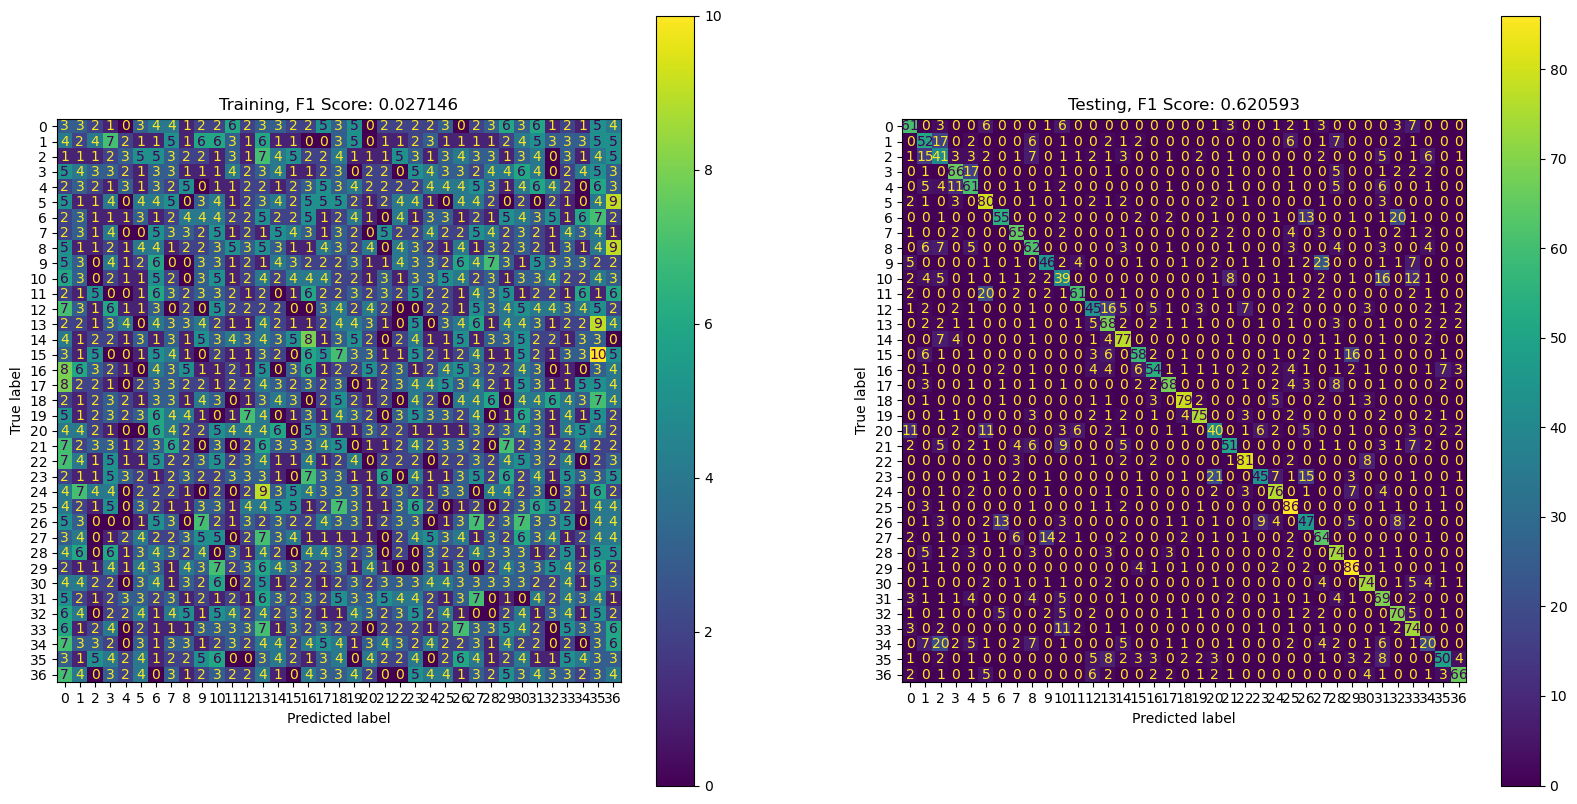

In [25]:
class_train, seg_train = mobile_model.predict(train_class_seg_off)
class_results, mask_results= mobile_model.predict(test_class_seg)
# predicted_labels = np.argmax(class_results, axis =1)

# eval_model_1(class_train, train_class_seg_off, y_train_class)
# eval_model_1(class_results, test_class_seg, y_test_class)
eval_model(class_train, train_class_seg_off, y_train_class, class_results, test_class_seg, y_test_class)

In [26]:
# x, y = next(iter(test_class_seg))
# classification, decoded = mobile_model(x)
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(tf.keras.preprocessing.image.array_to_img(x[0]))
# axs[1].imshow(tf.keras.preprocessing.image.array_to_img(decoded[0]))

58/58 [==============================] - 2s 40ms/step


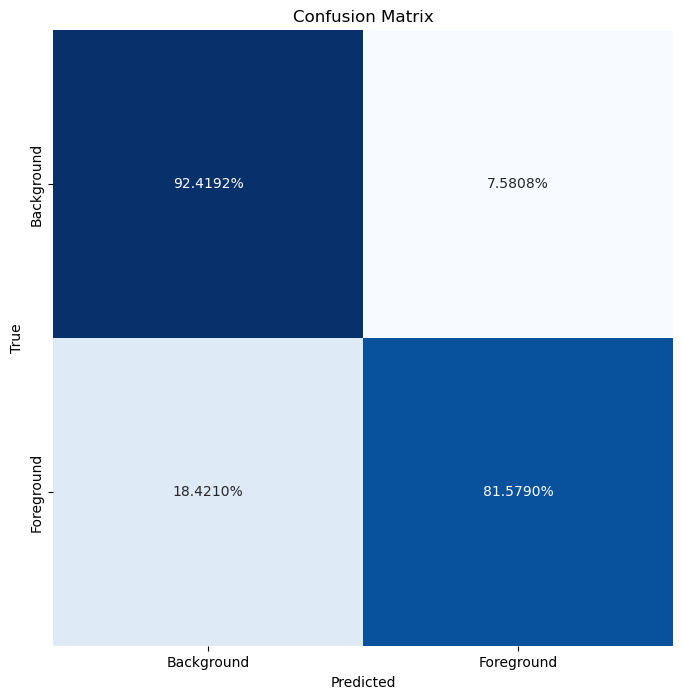

In [27]:
# class_preds, seg_preds = model_cnn.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = some_pred_y_data.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector

##### Simon email 
class_preds, seg_preds = mobile_model.predict(test_class_seg)
seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
seg_gt_flat = y_test_seg.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector


cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat, normalize='true')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt=".4%", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Background', 'Foreground'])
ax.yaxis.set_ticklabels(['Background', 'Foreground'])

# Display the plot
plt.show()


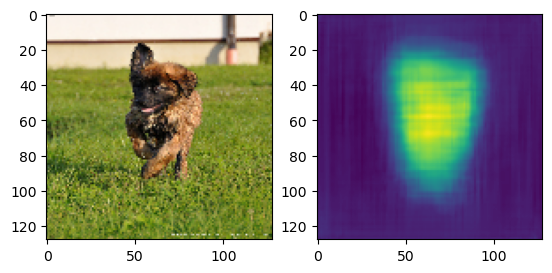

In [28]:
x, y = next(iter(test_class_seg))
classification, decoded = mobile_model(x)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(tf.keras.preprocessing.image.array_to_img(x[0]))
axs[1].imshow(tf.keras.preprocessing.image.array_to_img(decoded[0]))